# Boost factor of many halos

In [1]:
from prettyfigure.style import *

%matplotlib inline
from colossus.Cosmology import *
from colossus.HaloConcentration import *
from colossus.HaloDensityProfile import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import betainc

from dmb.single_halo import *
from dmb.mass_func import *

define_figure_style()
setCosmology('planck13')
cosmo = getCurrent()

In [2]:
z = 26.0
M_list = np.logspace(-8, 5, 1e2)

def myPS(M, Mcut, z, cosmo):
    '''
    My implementation of PS mass function
    :param M: mass
    :param z: redshift
    :param cosmo: cosmology
    :return:
    '''
    deltac = Cosmology.AST_delta_collapse
    R = cosmo.lagrangianR(M)
    sigma = cosmo.sigma(R, j=0, z=z)
    Rup = cosmo.lagrangianR(M*1.01)
    Rdw = cosmo.lagrangianR(M/1.01)
    dsigmadM = - (cosmo.sigma(Rup, j=0, z=z) - cosmo.sigma(Rdw, j=0, z=z)) / (0.02 * M)
    dndM = np.sqrt(2/np.pi) * np.exp(-deltac**2 / 2 / sigma**2) * deltac / sigma**2 * dsigmadM / M
    return dndM * (AST_rho_crit_0_Mpc3*cosmo.Om0) * np.exp(-(M/Mcut)**-0.666) * np.gradient(M)/np.gradient(np.log10(M))

def mf_Diemand(M, Mcut, cosmo):
    return 2.8e9*(M*cosmo.h)**-1*np.exp(-(M/Mcut)**-0.666) * cosmo.h**3


0.0249544292285
0.0380071048892


array([ 0.63587187,  0.63877098,  0.638739  ,  0.63870713,  0.63867536,
        0.63864371,  0.63861217,  0.63858074,  0.63854942,  0.63851821,
        0.63848711,  0.63845613,  0.63842525,  0.63839449,  0.63836384,
        0.6383333 ,  0.63830287,  0.63827256,  0.63824235,  0.63821226,
        0.63818228,  0.63815242,  0.63812266,  0.63809302,  0.6380635 ,
        0.63803408,  0.63800478,  0.63797559,  0.63794651,  0.63791755,
        0.6378887 ,  0.63785997,  0.63783135,  0.63780284,  0.63777444,
        0.63774616,  0.637718  ,  0.63768995,  0.63766201,  0.63763419,
        0.63760648,  0.63757889,  0.63755141,  0.63752405,  0.6374968 ,
        0.63746966,  0.63744265,  0.63741574,  0.63738896,  0.63736229,
        0.63733573,  0.63730929,  0.63728297,  0.63725676,  0.63723067,
        0.6372047 ,  0.63717884,  0.6371531 ,  0.63712747,  0.63710196,
        0.63707657,  0.6370513 ,  0.63702614,  0.6370011 ,  0.63697618,
        0.63695137,  0.63692668,  0.63690211,  0.63687766,  0.63

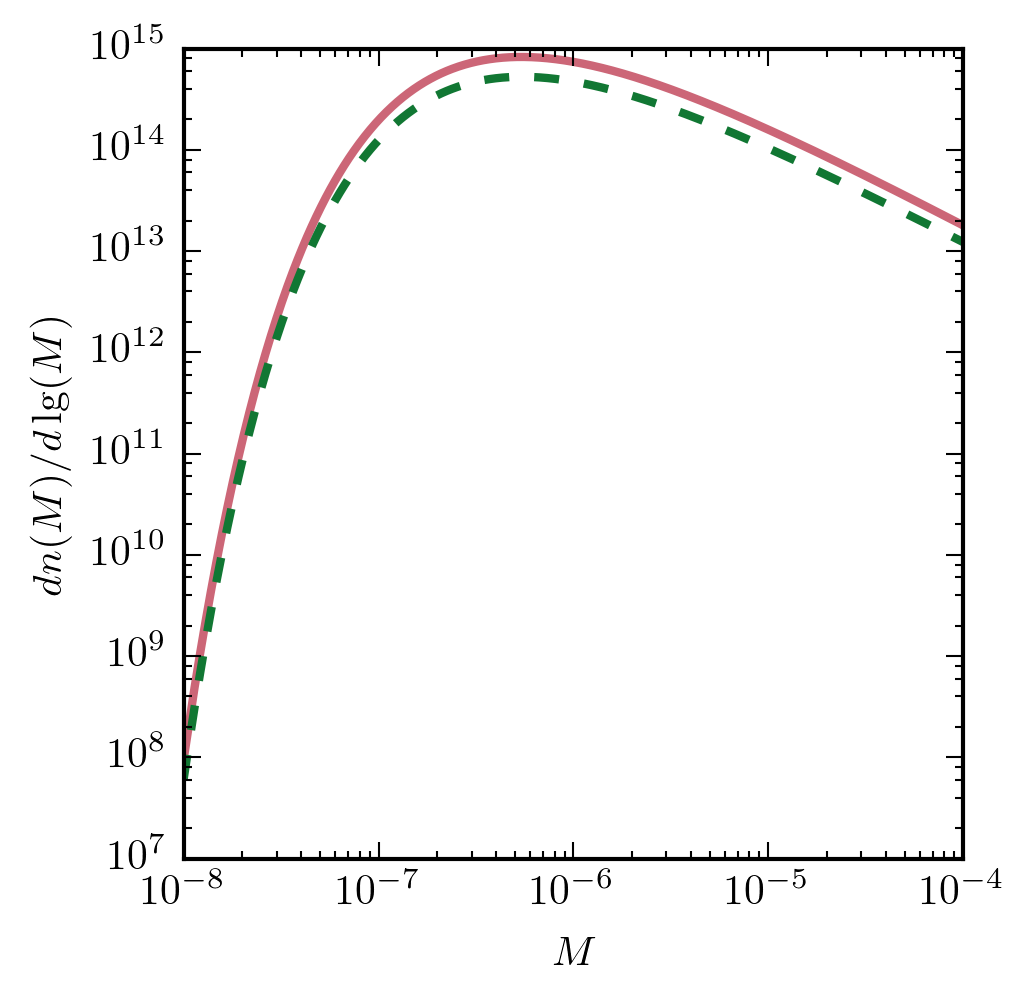

In [3]:

M_list = np.logspace(-8, -4, 1e3)

mf = myPS(M_list, 1e-6, z, cosmo)
plt.plot(M_list, mf)
plt.plot(M_list, mf_Diemand(M_list, 1e-6, cosmo) , '--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M$')
plt.ylabel(r'$dn(M)/d\lg(M)$')

print np.trapz(mf_Diemand(M_list, 1e-6, cosmo)*M_list, np.log10(M_list)) / (AST_rho_crit_0_Mpc3*cosmo.Om0)
print np.trapz(myPS(M_list, 1e-6, z, cosmo)*M_list, np.log10(M_list)) / (AST_rho_crit_0_Mpc3*cosmo.Om0)
mf_Diemand(M_list, 1e-6, cosmo) / myPS(M_list, 1e-6, z, cosmo)

In [ ]:
R_global = 0
M_list = np.logspace(-6, 1, 1e2)
z=1

mf = myPS(M_list, 1e-6, z, cosmo)

for i in range(len(M_list)-1):
#     print i, 
    M = M_list[i]
    alpha = IshiyamaAlpha(M, 1e-6)
    c = concentration(M, 'vir', z, model='diemer15')
#     profile = NFWProfile(M=M, mdef='vir', z=z, c=c)
#     rho0, rs = profile.fundamentalParameters(M, c, z, 'vir')
#     V = 4./3.*np.pi*Rmax**3
    B, V, c, rs = HaloBoost(z, M, c, alpha)
    Rmax = c*rs
    R_global += B * M**2 / V * mf[i] * np.diff(np.log10(M_list))[i]

print R_global / ((AST_rho_crit_0_Mpc3*cosmo.Om0)**2 / (1e9 / (1+z)**3))

In [ ]:
def GlobalBoosting(z, params):
    '''
    Global boosting factor
    :param z: redshift
    :param params: parameters
    :return: boosting factor
    '''
    cosmo = params['cosmo']
    Mcrit = 10**params['logMcrit']
    Ishiyama = params['Ishiyama']
    c_scatter = params['c_scatter']
    sub_params = params['subhalos']
    M_list = 10**np.arange(params['logMcrit'], 6.01, 0.5)
    R_global = 0
    mf = myPS(M_list, Mcrit, z, cosmo)
    for i in range(len(M_list)-1):
        M = M_list[i]
        if Ishiyama:
            alpha = IshiyamaAlpha(M, Mcrit)
        else:
            alpha = 1.0
        c = concentration(M, 'vir', z, model='diemer15')
        profile = NFWProfile(M=M, mdef='vir', z=z, c=c)
        rho0, rs = profile.fundamentalParameters(M, c, z, 'vir')
        Rmax = c*rs
        V = 4./3.*np.pi*Rmax**3
#         Bt, V, c, rs  = HaloBoost_c(z, M, c, alpha, params['c_scatter'])   
        if sub_params:
            a, b = HaloBoost_sub(z,M,c_scatter,Mcrit,0.012,2.,Ishiyama=Ishiyama)
            B = 1.0*b
            V = a[1]
            c = a[2]
            rs = a[3]
#             print np.log10(M), B, Bt
        else:
            if params['c_scatter']<1e-5:
                B, V, c, rs  = HaloBoost(z, M, c, alpha)
            else:
                B, V, c, rs  = HaloBoost_c(z, M, c, alpha, params['c_scatter'])    
        R_global += B * M**2 / V * mf[i] * np.diff(np.log10(M_list))[i]
    return R_global / ((AST_rho_crit_0_Mpc3*cosmo.Om0)**2 / (1e9 / (1+z)**3))

In [ ]:
def HaloBoost(z, M, c, alpha):
    '''
    Boosting factor of an individual halo
    :param z: redshift of the halo
    :param M: mass of the halo (in Msun)
    :param c: concentration
    :param alpha: inner slope
    :return: Boosting factor of an individual halo
    '''
    profile = NFWProfile(M=M, mdef='vir', z=z, c=c)
    rho0, rs = profile.fundamentalParameters(M, c, z, 'vir')
    Rmax= c*rs
    if alpha==1:
        R = np.logspace(np.log10(rs)-4, np.log10(Rmax), 1000)
    else:
        R = np.logspace(np.log10(Rmax)-24, np.log10(Rmax), 1000)
    rho = NFWa(R, rs, rho0, alpha=alpha)
    V = np.concatenate([[0], 4./3.*np.pi*R**3])
    V = np.diff(V)
    rho2V = rho**2*V
#     print np.sum(rho*V)
#     plt.plot(rho2V,'-+')
    B_nu = rho2V.sum() * V.sum() / M**2
    return B_nu, V.sum(), c, rs

def HaloBoost2(z, M, c, alpha):
    '''
    Boosting factor of an individual halo
    :param z: redshift of the halo
    :param M: mass of the halo (in Msun)
    :param c: concentration
    :param alpha: inner slope
    :return: Boosting factor of an individual halo
    '''
    profile = NFWProfile(M=M, mdef='vir', z=z, c=c)
    rho0, rs = profile.fundamentalParameters(M, c, z, 'vir')
    Rmax= c*rs
    if alpha==1:
        R = np.logspace(np.log10(rs)-4, np.log10(Rmax)+0, 10000)
    else:
        R = np.logspace(np.log10(Rmax)-24, np.log10(Rmax), 1000)
    rho = NFWa(R, rs, rho0, alpha=alpha)
    V = np.concatenate([[0], 4./3.*np.pi*R**3])
    V = np.diff(V)
    rho2V = rho**2*V
#     print np.sum(rho*V)
#     plt.plot(rho2V,'-+')
    rho_mean = (AST_rho_crit_0_kpc3*(1+z)**3*cosmo.Om0)
    equiv_V = M / rho_mean
    B_nu = rho2V.sum() / (rho_mean**2*equiv_V)
    return B_nu, V.sum(), c, rs

a,b,c,d = HaloBoost(10.0,1e6,3.0,1.0)
print a

a,b,c,d = HaloBoost2(10.0,1e6,3.0,1.0)
print a

In [ ]:
params = {'logMcrit': -6, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': False}
print GlobalBoosting(10.0, params)
params = {'logMcrit': -6, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True}
print GlobalBoosting(10.0, params)

In [ ]:
z_list = np.logspace(0, np.log10(150), 10)
B_list = np.zeros(len(z_list))
import numpy as np
from scipy.optimize import curve_fit
def BoostFit(x, a, b, c, d):
    return np.log10(a * (x)**b * np.exp(-((1+x)/c)**d) + 1e-1)

def BoostF(x, a, b, c, d):
    return a * (x)**b * np.exp(-((1+x)/c)**d)

for params in [{'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True},\
               {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True},\
               {'logMcrit': -12, 'Ishiyama': True, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True}]:
    for i in range(len(z_list)):
        print i,
        B_list[i] = GlobalBoosting(z_list[i], params)

    popt, pcov = curve_fit(BoostFit, z_list, np.log10(B_list + 1e-1), p0=[1e5,-1.2, 35.0, 2.0], absolute_sigma = True)
    print popt

In [ ]:
z_list = np.logspace(0, np.log10(150), 10)
B_list = np.zeros(len(z_list))

for params in [{'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': False}]:
    for i in range(len(z_list)):
        print i,
        B_list[i] = GlobalBoosting(z_list[i], params)

    popt, pcov = curve_fit(BoostFit, z_list, np.log10(B_list + 1e-1), p0=[1e5,-1.2, 35.0, 2.0], absolute_sigma = True)
    print popt

In [ ]:


plt.plot(z_list,B_list+1,lw=1)
plt.plot(z_list,BoostF(z_list, popt[0], popt[1], popt[2], popt[3])+1,'--')
plt.xscale('log')
plt.yscale('log')


In [4]:
def CLfit(z, paramsx):
    popt = [0,0,0,0]
    params = paramsx.copy()
    factor = params['factor']
    del params['factor']
    # Pessimistic
    if params == {'logMcrit': -6, 'Ishiyama': False, 'c_scatter': 0.08, 'cosmo': cosmo, 'subhalos': False}:
        popt = [  1.84649743e+04,  -1.02753619e+00,   2.46528943e+01,   1.82809696e+00]
    # Realistic
    if params == {'logMcrit': -9, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True}:
        popt = [  4.54957836e+04,  -1.18439346e+00,   2.83227492e+01,   1.76984018e+00]
    # Optimistic
    if params == {'logMcrit': -12, 'Ishiyama': True, 'c_scatter': 0.24, 'cosmo': cosmo, 'subhalos': True}:
        popt = [  2.05248493e+06,  -1.41667156e+00,   4.17925455e+01,   2.09477611e+00]
    # No sub-halo
    if params == {'logMcrit': -9, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': False}:
        popt = [  3.29365151e+04,  -1.11127683e+00,   2.91912178e+01,   1.82020814e+00]
    if params == {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': False}:
        popt = [  3.23447920e+05,  -1.16443863e+00,   4.23890668e+01,   2.45962644e+00]
    # With mNFW
    if params == {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True}:
        popt = [  5.59555238e+05,  -1.30461364e+00,   3.88430632e+01,   2.21880041e+00]    
    # Vary Mcrit
    if params == {'logMcrit': -12, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True}:
        popt = [  6.59796852e+04,  -1.22289653e+00,   3.12134666e+01,   1.67865004e+00]
    if params == {'logMcrit': -6, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True}:
        popt = [  3.00818166e+04,  -1.12075206e+00,   2.39200911e+01,   1.76339590e+00]
    # Cirelli
    if params == {'logMcrit': -3, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': False}:
        popt = [  1.67776555e+04,  -1.03700269e+00,   2.04698107e+01,   1.84096902e+00]
    if params == {'logMcrit': -6, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': False}:
        popt = [  2.44497415e+04,  -1.07777648e+00,   2.46684514e+01,   1.81837757e+00]
    if params == {'logMcrit': -9, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': False}:
        popt = [  3.29365151e+04,  -1.11127683e+00,   2.91912178e+01,   1.82020814e+00]
    a, b, c, d = popt
    return factor * a * (z)**b * np.exp(-((1+z)/c)**d) + 1


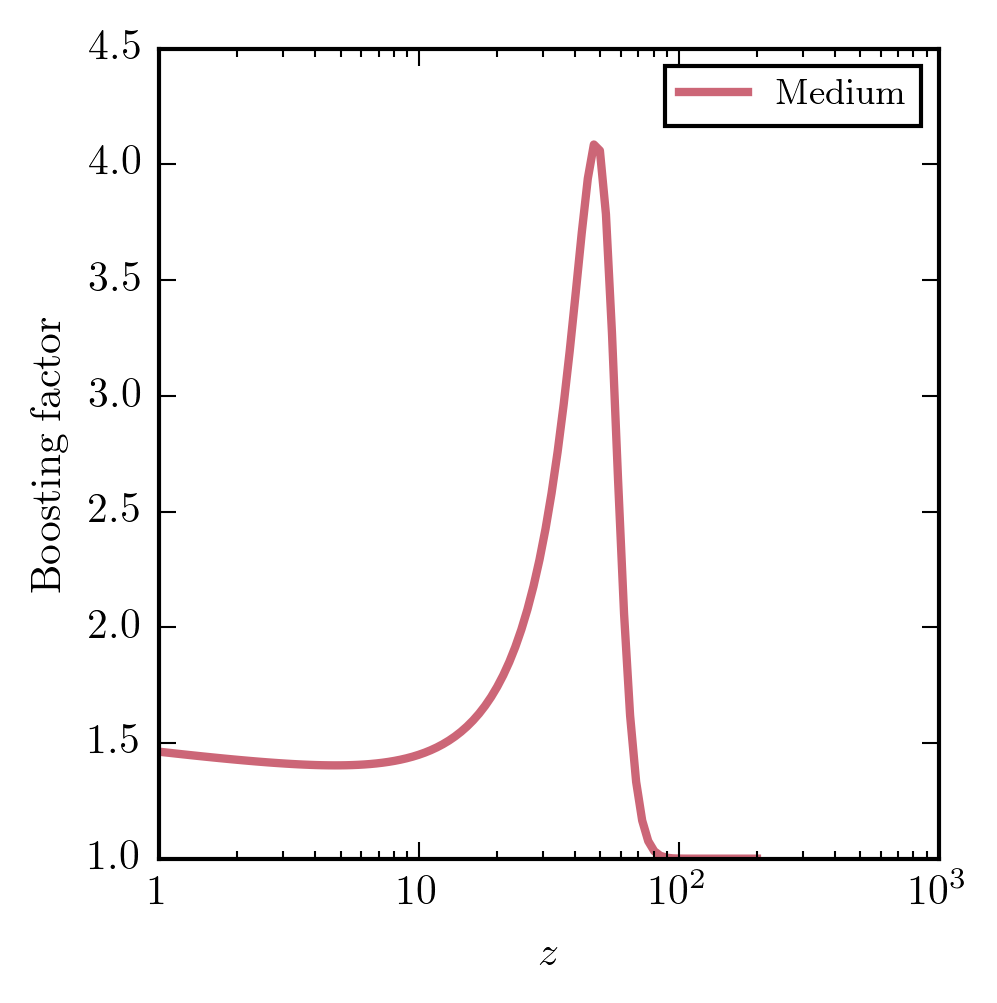

In [5]:
z_list = np.logspace(0, np.log10(200), 100)
params =  {'logMcrit': -3, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': False, 'factor': 1.0}
temp = CLfit(z_list, params)
params =  {'logMcrit': -6, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': False, 'factor': 1.0}
plt.plot(z_list, CLfit(z_list, params)/temp, '-', label=r'$\mathrm{Medium}$')
plt.xscale('log')
# plt.yscale('log')
plt.legend(loc=1)
fixlogax(plt.gca())
# fixlogax(plt.gca(), 'y')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{Boosting\;factor}$')

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


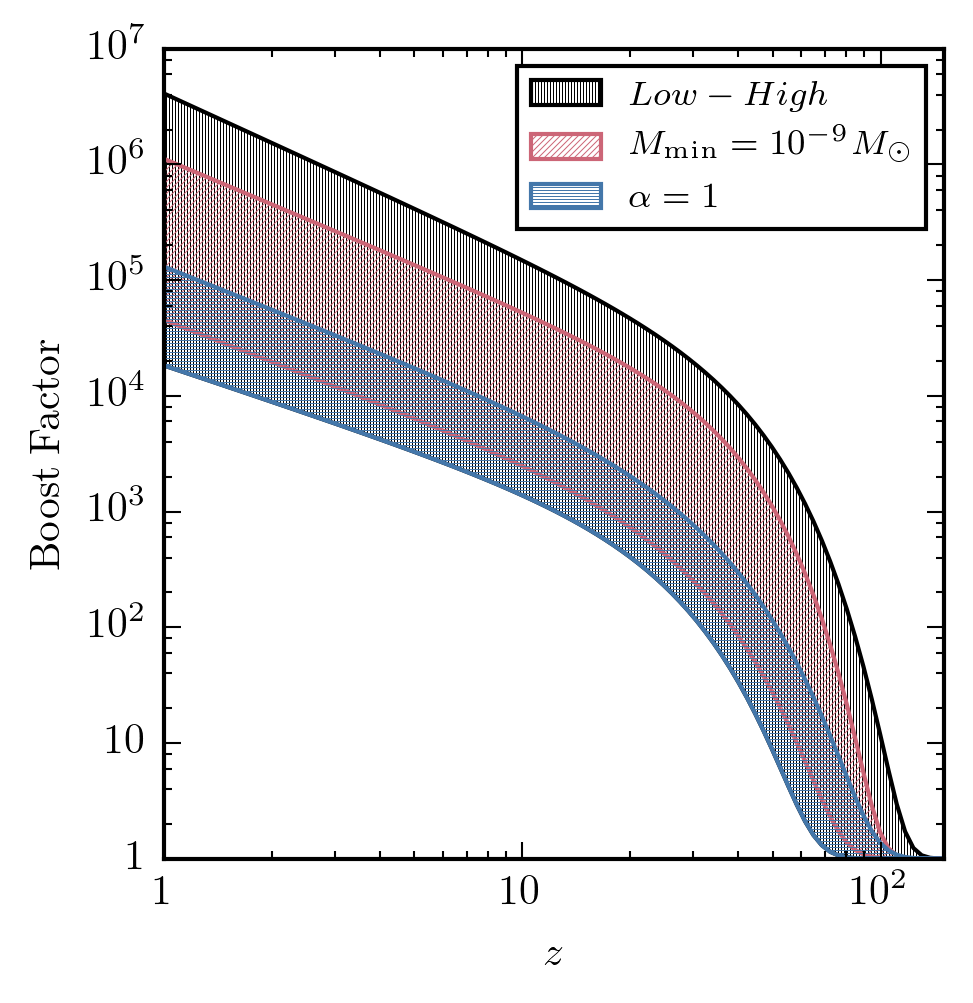

In [6]:
import matplotlib as mpl
colors = mpl.rcParams['axes.color_cycle']

# Extreemes
z_list = np.logspace(0, np.log10(200), 100)
# params =  {'logMcrit': -12, 'Ishiyama': True, 'c_scatter': 0.24, 'cosmo': cosmo, 'subhalos': True}
# plt.plot(z_list, CLfit(z_list, params), '-.', label=r'$\mathrm{High}$')
# params =  {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True}
# plt.plot(z_list, CLfit(z_list, params), '-', label=r'$\mathrm{Medium}$')
# params =  {'logMcrit': -9, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True}
# plt.plot(z_list, CLfit(z_list, params), '-', label=r'$\mathrm{Medium}$')
# params =  {'logMcrit': -6, 'Ishiyama': False, 'c_scatter': 0.08, 'cosmo': cosmo, 'subhalos': False}
# plt.plot(z_list, CLfit(z_list, params), '--', label=r'$\mathrm{Low}$')
params =  {'logMcrit': -12, 'Ishiyama': True, 'c_scatter': 0.24, 'cosmo': cosmo, 'subhalos': True, 'factor':2}
top = CLfit(z_list, params)
params =  {'logMcrit': -6, 'Ishiyama': False, 'c_scatter': 0.08, 'cosmo': cosmo, 'subhalos': False, 'factor':1}
bot = CLfit(z_list, params)
plt.fill_between(z_list, bot, top, facecolor='None', hatch='||||')
p1 = plt.Rectangle((0, 0), 1, 1, facecolor='none',edgecolor='k', hatch='||||')

params =  {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True, 'factor':2}
top = CLfit(z_list, params)
params =  {'logMcrit': -9, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True, 'factor':1}
bot = CLfit(z_list, params)
plt.fill_between(z_list, bot, top, facecolor='None', edgecolor=colors[0], hatch='////')
p2 = plt.Rectangle((0, 0), 1, 1, facecolor='none',edgecolor=colors[0], hatch='////')

params =  {'logMcrit': -12, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True, 'factor':2}
top = CLfit(z_list, params)
params =  {'logMcrit': -6, 'Ishiyama': False, 'c_scatter': 0.08, 'cosmo': cosmo, 'subhalos': False, 'factor':1}
bot = CLfit(z_list, params)

plt.fill_between(z_list, bot, top, facecolor='None', edgecolor=colors[2], hatch='----')
p3 = plt.Rectangle((0, 0), 1, 1, facecolor='none',edgecolor=colors[2], hatch='----')

plt.xscale('log')
plt.yscale('log')
plt.xlim([1,150])
plt.legend([p1, p2, p3],[r'$Low-High$',r'$M_\mathrm{min}=10^{-9}M_\odot$',r'$\alpha=1$'],loc=1)
fixlogax(plt.gca())
fixlogax(plt.gca(), 'y')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{Boost\;Factor}$')
plt.savefig('extremes.png', dpi=300)
plt.savefig('extremes.pdf')

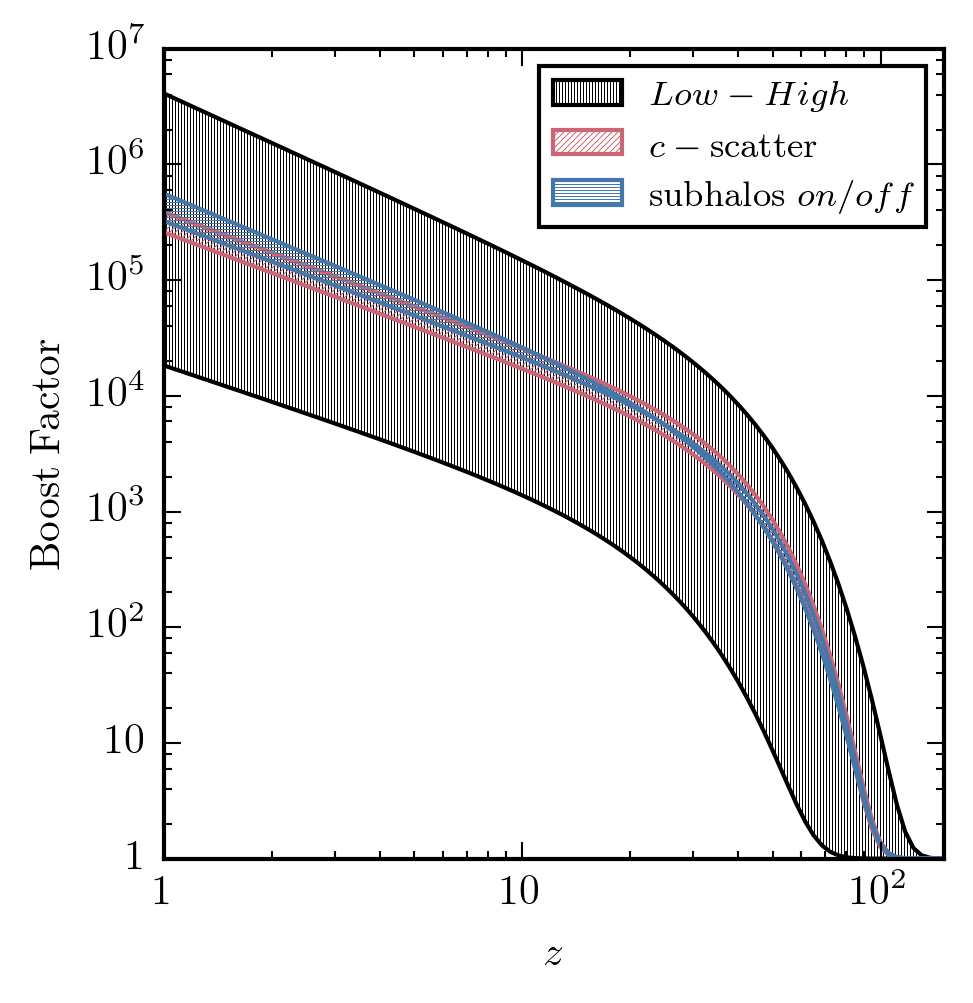

In [7]:
# Extreemes
z_list = np.logspace(0, np.log10(200), 100)
# params =  {'logMcrit': -12, 'Ishiyama': True, 'c_scatter': 0.24, 'cosmo': cosmo, 'subhalos': True}
# plt.plot(z_list, CLfit(z_list, params), '-.', label=r'$\mathrm{High}$')
# params =  {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True}
# plt.plot(z_list, CLfit(z_list, params), '-', label=r'$\mathrm{Medium}$')
# params =  {'logMcrit': -9, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True}
# plt.plot(z_list, CLfit(z_list, params), '-', label=r'$\mathrm{Medium}$')
# params =  {'logMcrit': -6, 'Ishiyama': False, 'c_scatter': 0.08, 'cosmo': cosmo, 'subhalos': False}
# plt.plot(z_list, CLfit(z_list, params), '--', label=r'$\mathrm{Low}$')

params =  {'logMcrit': -12, 'Ishiyama': True, 'c_scatter': 0.24, 'cosmo': cosmo, 'subhalos': True, 'factor':2}
top = CLfit(z_list, params)
params =  {'logMcrit': -6, 'Ishiyama': False, 'c_scatter': 0.08, 'cosmo': cosmo, 'subhalos': False, 'factor':1}
bot = CLfit(z_list, params)
plt.fill_between(z_list, bot, top, facecolor='None', hatch='||||')
p1 = plt.Rectangle((0, 0), 1, 1, facecolor='none',edgecolor='k', hatch='||||')


params =  {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': False, 'factor':1}
top = (CLfit(z_list, params)-1)*1.2+1
params =  {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': False, 'factor':1}
bot = (CLfit(z_list, params)-1)*0.8+1
plt.fill_between(z_list, bot, top, facecolor='None', edgecolor=colors[0], hatch='////')
p2 = plt.Rectangle((0, 0), 1, 1, facecolor='none',edgecolor=colors[0], hatch='////')

params =  {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True, 'factor':1}
top = CLfit(z_list, params)
params =  {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': False, 'factor':1}
bot = CLfit(z_list, params)
plt.fill_between(z_list, bot, top, facecolor='None', edgecolor=colors[2], hatch='----')
p3 = plt.Rectangle((0, 0), 1, 1, facecolor='none',edgecolor=colors[2], hatch='----')

plt.xscale('log')
plt.yscale('log')
plt.xlim([1,150])
plt.legend([p1, p2, p3],[r'$Low-High$',r'$c-\mathrm{scatter}$',r'$\mathrm{subhalos}\;on/off$'],loc=1)
fixlogax(plt.gca())
fixlogax(plt.gca(), 'y')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{Boost\;Factor}$')
plt.savefig('lessimportant.png', dpi=300)
plt.savefig('lessimportant.pdf')

In [ ]:
# Vary Mcrit
z_list = np.logspace(0, np.log10(200), 100)
params =  {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0.20, 'cosmo': cosmo, 'subhalos': True, 'factor': 1.0}
plt.plot(z_list, CLfit(z_list, params), '-.', label=r'$\sigma_{\log_{10}c}=0.20$')
params =  {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True, 'factor': 1.0}
plt.plot(z_list, CLfit(z_list, params), '-', label=r'$\sigma_{\log_{10}c}=0.15$')
params =  {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0.10, 'cosmo': cosmo, 'subhalos': True, 'factor': 1.0}
plt.plot(z_list, CLfit(z_list, params), '--', label=r'$\sigma_{\log_{10}c}=0.10$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=1)
fixlogax(plt.gca())
fixlogax(plt.gca(), 'y')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{Boosting\;factor}$')
plt.savefig('c_scatter.pdf')

In [ ]:
# Vary Mcrit
z_list = np.logspace(0, np.log10(200), 100)
params =  {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}
plt.plot(z_list, CLfit(z_list, params), '-', label=r'$\alpha\neq const$')
params =  {'logMcrit': -6, 'Ishiyama': False, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}
plt.plot(z_list, CLfit(z_list, params), '--', label=r'$\alpha=1$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=1)
fixlogax(plt.gca())
fixlogax(plt.gca(), 'y')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{Boosting\;factor}$')
plt.savefig('alpha.pdf')

In [ ]:
# Vary subhalos
z_list = np.logspace(0, np.log10(200), 100)
params =  {'logMcrit': -9, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True}
plt.plot(z_list, CLfit(z_list, params), '-', label=r'$\mathrm{with\;subhalos}$')
params =  {'logMcrit': -9, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': False}
plt.plot(z_list, CLfit(z_list, params), '--', label=r'$\mathrm{no\;subhalos}$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=1)
fixlogax(plt.gca())
fixlogax(plt.gca(), 'y')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{Boosting\;factor}$')
plt.savefig('subhalos.pdf')

In [ ]:
# Vary subhalos
z_list = np.logspace(0, np.log10(200), 100)
params =  {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True}
plt.plot(z_list, CLfit(z_list, params), '-', label=r'$\mathrm{with\;subhalos}$')
params =  {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': False}
plt.plot(z_list, CLfit(z_list, params), '-', label=r'$\mathrm{with\;subhalos}$')
params =  {'logMcrit': -9, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': True}
plt.plot(z_list, CLfit(z_list, params), '--', label=r'$\mathrm{no\;subhalos}$')
params =  {'logMcrit': -9, 'Ishiyama': False, 'c_scatter': 0.16, 'cosmo': cosmo, 'subhalos': False}
plt.plot(z_list, CLfit(z_list, params), '--', label=r'$\mathrm{no\;subhalos}$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=1)
fixlogax(plt.gca())
fixlogax(plt.gca(), 'y')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{Boosting\;factor}$')
plt.savefig('subhalos_plus_alpha.pdf')